# Feature analysis

Input datasets:
- training_data_MS_iso_filter.csv
- training_data_MS_filter.csv
- training_data.csv

This notebook includes:
- Test for significance and FDR
- Feature correlation
- Violin plots (continuous features)
- Barplots (categorical features)

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import os

from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import fdrcorrection
from matplotlib_venn import venn2
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Define paths

In [2]:
Data_path = os.path.dirname(os.getcwd()) + '/Data'

## Import dataset

### Human proteome

In [3]:
hp = pd.read_csv(Data_path + '/curated/features_human_proteome.csv', sep=',')

### Molecular weight of human proteome

In [4]:
MS_all = pd.read_csv(Data_path + "/mapping/MS_proteome_UP_MW.tab", sep="\t")

MS_all["Mass"] = MS_all["Mass"].str.replace(',','').astype(float)
MS_all["Mass_log"] = MS_all["Mass"].transform(np.log2)

### Feature datasets

In [5]:
df_MS_iso_filter = pd.read_csv(Data_path + '/training/training_data_MS_iso_filter.csv')
df_MS_filter = pd.read_csv(Data_path + '/training/training_data_MS_filter.csv')
df_unfiltered = pd.read_csv(Data_path + '/training/training_data_no_filter.csv')

In [6]:
print("Proteins in isolation workflow and MS filtered dataset:", len(df_MS_iso_filter))
print("Proteins in MS filtered dataset:", len(df_MS_filter))
print("Proteins in unfiltered dataset:", len(df_unfiltered))

Proteins in isolation workflow and MS filtered dataset: 16255
Proteins in MS filtered dataset: 13709
Proteins in unfiltered dataset: 16929


In [7]:
EV_MS_iso_1 = df_MS_iso_filter[df_MS_iso_filter["EV"] == 1]
EV_MS_iso_0 = df_MS_iso_filter[df_MS_iso_filter["EV"] == 0]

EV_MS_1 = df_MS_filter[df_MS_filter["EV"] == 1]
EV_MS_0 = df_MS_filter[df_MS_filter["EV"] == 0]

EV_unfiltered_1 = df_unfiltered[df_unfiltered["EV"] == 1]
EV_unfiltered_0 = df_unfiltered[df_unfiltered["EV"] == 0]

## Statistical significance testing

In [8]:
continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 
    'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 
    'thsa_netsurfp2', 'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 
    'E_exposed', 'F_exposed', 'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 
    'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 
    'Y_exposed', 'Probability_solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 
    'Gravy', 'Isoelectric_point', 'Charge_at_7', 'Charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

categorical = ['HSP', 'PTM_Uniprot', 'Citrullination_Uniprot', 'GPI-anchor_Uniprot', 'Nitration_Uniprot', 
    'Prenylation_Uniprot', 'ISGylation_Uniprot', 'NEDDylation_Uniprot', 'Acetylation_all', 'Glycosylation_all', 
    'Methylation_all', 'Myristoylation_all', 'Nitrosylation_all', 'Palmitoylation_all', 'Phosphorylation_all', 
    'SUMOylation_all', 'Ubiquitination_all', 'PTM_MSD', 'Phosphorylation_MSD', 'Glycosylation_MSD', 
    'Ubiquitination_MSD', 'SUMOylation_MSD', 'Acetylation_MSD',  'Palmitoylation_MSD', 'Methylation_MSD', 
    'coiled_coil', 'RAS_profile', 'ww_domain', 'EGF', 'RRM', 'transmembrane', 'TMHMM']

In [9]:
def calculate_p_value_continuous(EV_df, non_EV_df, feature):
    
    stat, p = mannwhitneyu(EV_df[feature], non_EV_df[feature]) # function return statistic and p-value
    return p


def calculate_p_value_categorical(EV_df, non_EV_df, feature):
    
    # get counts for each category
    A = sum(EV_df[feature]) # EV & positive
    B = len(EV_df[feature]) - sum(EV_df[feature]) # EV & negative
    C = sum(non_EV_df[feature]) # no EV & positive
    D = len(non_EV_df[feature]) - sum(non_EV_df[feature]) # no EV & negative
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B], [C, D]])
    odds, p = fisher_exact(table, alternative="two-sided") # function return odds ratio and p-value
    return p


def test_statistical_significance(EV_df, non_EV_df):

    p_vals = pd.Series(index=continuous+categorical, dtype="float64", name="P_value")

    for feature in continuous:
        p = calculate_p_value_continuous(EV_df, non_EV_df, feature)
        p_vals.loc[feature] = p 
        
    for feature in categorical:
        p = calculate_p_value_categorical(EV_df, non_EV_df, feature)
        p_vals.loc[feature] = p 
        
    # calculate adjusted p-value (FDR correction)
    rejected, p_vals_adj = fdrcorrection(p_vals)
    p_vals_adj = pd.Series(data=p_vals_adj, index=continuous+categorical, name="P_value_adjusted")   
    p_vals = pd.concat([p_vals, p_vals_adj], axis=1)
        
    return p_vals

In [10]:
# save P-value dataframe
EV_MS_iso_p_vals = test_statistical_significance(EV_MS_iso_1, EV_MS_iso_0)
EV_MS_iso_p_vals.to_csv(Data_path + '/MS_iso_filter_P_values.csv')

In [11]:
EV_MS_p_vals = test_statistical_significance(EV_MS_1, EV_MS_0)
EV_unfiltered_p_vals = test_statistical_significance(EV_unfiltered_1, EV_unfiltered_0)

# Feature correlation

In [12]:
# calculate pairwise correlation
corr_all = df_MS_iso_filter.corr()

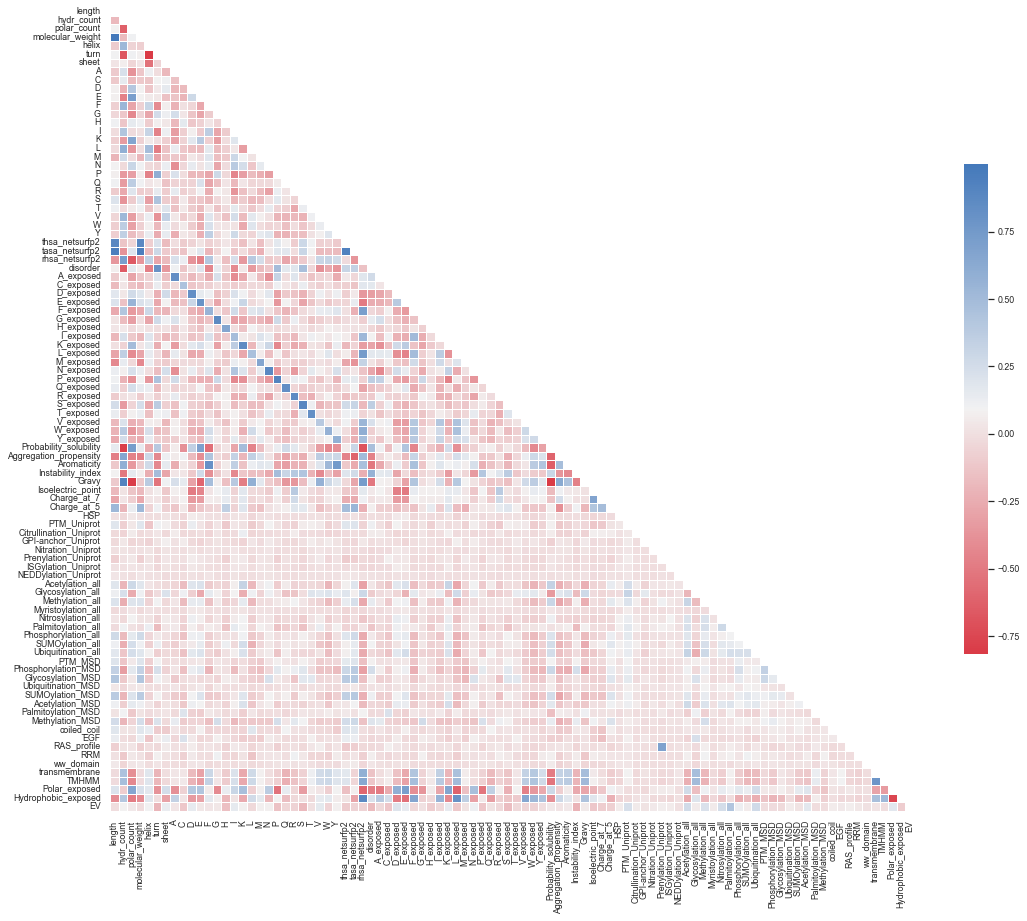

In [13]:
# figure settings
sns.set(font_scale=0.8, style="white")
fig, ax = plt.subplots(figsize=(18, 18))

mask = np.triu(np.ones_like(corr_all, dtype=np.bool))
cmap = sns.diverging_palette(10, 250, as_cmap=True)

sns.heatmap(corr_all, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax,
            xticklabels=True, yticklabels=True)

plt.show()

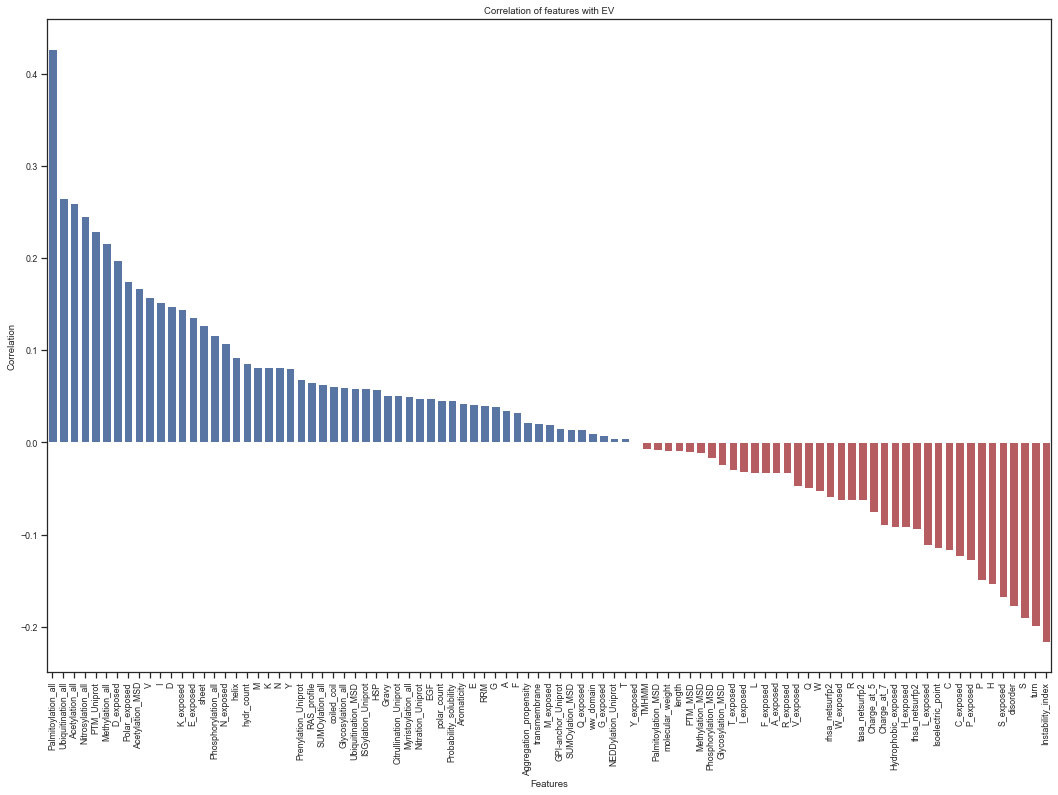

In [14]:
# figure settings
sns.set(style=("ticks"), font_scale=0.8)
fig, ax = plt.subplots(figsize=(18, 12)) 

correlations_all = corr_all[["EV"]].sort_values(by="EV", ascending=False)[1:]
correlations_all.reset_index(inplace=True)

colors_all = ["b" if (x > 0) else "r" for x in correlations_all["EV"]]

sns.barplot(x="index", y="EV", data=correlations_all, palette=colors_all)
ax.set(title="Correlation of features with EV", xlabel="Features", ylabel="Correlation")
plt.xticks(rotation=90)

plt.show()

## PTM Barplots

In [15]:
cols = ['PTM_Uniprot', 'Citrullination_Uniprot', 'GPI-anchor_Uniprot', 'Nitration_Uniprot', 'Prenylation_Uniprot', 
    'ISGylation_Uniprot', 'NEDDylation_Uniprot', 'Acetylation_all', 'Glycosylation_all', 'Methylation_all', 
    'Myristoylation_all', 'Nitrosylation_all', 'Palmitoylation_all', 'Phosphorylation_all', 'SUMOylation_all', 
    'Ubiquitination_all', 'coiled_coil', 'EGF', 'RAS_profile', 'RRM', 'ww_domain']

labels=['Isolation workflow and MS\nfiltered dataset (EV)', 'Isolation workflow and MS\nfiltered dataset (non-EV)',
        'MS filtered dataset (EV)', 'MS filtered dataset (non-EV)', 
        'Unfiltered dataset (EV)', 'Unfiltered dataset (non-EV)', ]

def get_ptm_dataframes(df, cols):
    
    df_PTM = df[cols + ["EV"]]
    
    # create subsets of PTM dataframe
    df_PTM_1 = df_PTM[df_PTM["EV"] == 1]
    df_PTM_0 = df_PTM[df_PTM["EV"] == 0]

    # drop vesicle column
    df_PTM_1.drop(columns=["EV"], inplace=True)
    df_PTM_0.drop(columns=["EV"], inplace=True)
    
    return df_PTM_1, df_PTM_0


def create_melted_ptm_dataframe(df_1, df_0):
    
    df_fraction = pd.DataFrame(data={'PTM': df_1.columns, 
                                  'EV':df_1.sum().values/len(df_1), 
                                  'non-EV':df_0.sum().values/len(df_0)})
    df_melted = df_fraction.melt(id_vars=["PTM"], var_name="Vesicle", value_name="Fraction")
    df_melted.sort_values(["PTM", "Vesicle"], inplace=True)    
    
    return df_melted


def create_subset(ptm, df_list):
    
    df_ptm_list = []
    
    for df in df_list:
        df_ptm = df[df["PTM"].str.contains(ptm)]
        df_ptm_list.append(df_ptm)
    
    # concatenate into one dataframe
    df_combined_ptm = pd.concat(df_ptm_list)
    
    return df_combined_ptm


def print_p_val(p_val):
    
    if p_val < 0.0001:
        return "< 0.0001"
    else:
        return "%.4f" % p_val

In [16]:
df_MS_iso_PTM_1, df_MS_iso_PTM_0 = get_ptm_dataframes(df_MS_iso_filter, cols)
df_MS_PTM_1, df_MS_PTM_0 = get_ptm_dataframes(df_MS_filter, cols)
df_unfiltered_PTM_1, df_unfiltered_PTM_0 = get_ptm_dataframes(df_unfiltered, cols)

# create melted dataframe of all PTM fractions in EV and non-EV group
df_MS_iso_PTM_melted = create_melted_ptm_dataframe(df_MS_iso_PTM_1, df_MS_iso_PTM_0)
df_MS_PTM_melted = create_melted_ptm_dataframe(df_MS_PTM_1, df_MS_PTM_0)
df_unfiltered_PTM_melted = create_melted_ptm_dataframe(df_unfiltered_PTM_1, df_unfiltered_PTM_0)

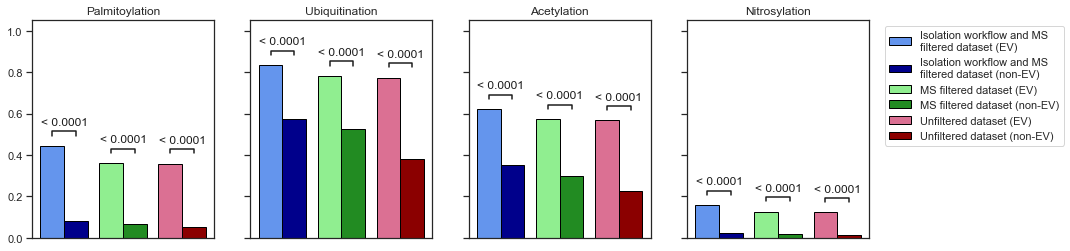

In [17]:
# create subsets of dataframes for PTM types to be plotted
PTMs = ["Palmitoylation_all", "Ubiquitination_all", "Acetylation_all", "Nitrosylation_all"]
names_PTMs = ["Palmitoylation", "Ubiquitination", "Acetylation", "Nitrosylation"]

subsets = []
for i in PTMs:
    subset = create_subset(i, [df_MS_iso_PTM_melted, df_MS_PTM_melted, df_unfiltered_PTM_melted])
    subsets.append(subset)

# figure settings
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(15, 4))
plt.ylim((0, 1.05))   

x1 = [1, 3, 5]
x2 = [1.8, 3.8, 5.8]

for i, data in enumerate(subsets):
    axs[i].bar([1, 1.8, 3, 3.8, 5, 5.8], data["Fraction"], color=["cornflowerblue", "darkblue", "lightgreen", "forestgreen",
        "palevioletred", "darkred"], edgecolor="black")
    axs[i].set(xlabel=None, ylabel=None, title=names_PTMs[i], xticks=[])
    y, h = data['Fraction'].iloc[0] + 0.05, 0.02
    axs[i].plot([1, 1, 1.8, 1.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((1+1.8)*0.5, y+h+0.02, print_p_val(EV_MS_iso_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', 
        va='bottom', color='k')
    y, h = data['Fraction'].iloc[2] + 0.05, 0.02
    axs[i].plot([3, 3, 3.8, 3.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((3+3.8)*.5, y+h+0.02, print_p_val(EV_MS_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', va='bottom', 
        color='k')
    y, h = data['Fraction'].iloc[4] + 0.05, 0.02
    axs[i].plot([5, 5, 5.8, 5.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((5+5.8)*.5, y+h+0.02, print_p_val(EV_unfiltered_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', 
        va='bottom', color='k')   
    # add legend outside of plots
    if i == 3:
        axs[i].legend(handles=axs[i].patches, labels=labels, bbox_to_anchor=(2.1, 1))
        
plt.show()

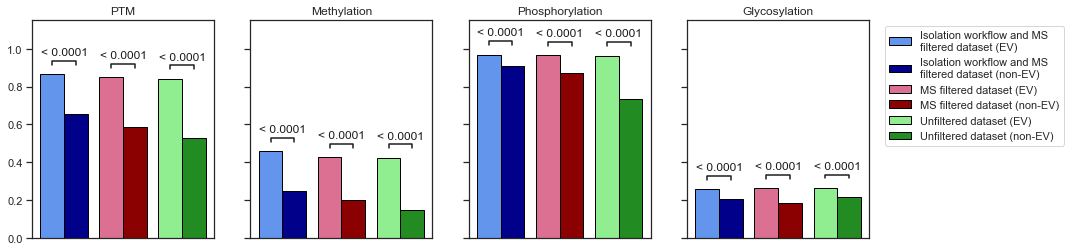

In [18]:
# create subsets of dataframes for PTM types to be plotted
PTMs = ["PTM_Uniprot", "Methylation_all", "Phosphorylation_all", "Glycosylation_all"]
names_PTMs = ["PTM", "Methylation", "Phosphorylation", "Glycosylation"]
subsets = []
for i in PTMs:
    subset = create_subset(i, [df_MS_iso_PTM_melted, df_MS_PTM_melted, df_unfiltered_PTM_melted])
    subsets.append(subset)

# figure settings
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(15, 4))
plt.ylim((0, 1.15))   

x1 = [1, 3, 5]
x2 = [1.8, 3.8, 5.8]

for i, data in enumerate(subsets):
    axs[i].bar([1, 1.8, 3, 3.8, 5, 5.8], data["Fraction"], color=["cornflowerblue", "darkblue", "palevioletred", "darkred", 
        "lightgreen", "forestgreen"], edgecolor="black")
    axs[i].set(xlabel=None, ylabel=None, title=names_PTMs[i], xticks=[])
    y, h = data['Fraction'].iloc[0] + 0.05, 0.02
    axs[i].plot([1, 1, 1.8, 1.8], [y, y+h, y+h, y], lw=1.5, c='k') 
    axs[i].text((1+1.8)*0.5, y+h+0.02, print_p_val(EV_MS_iso_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', va='bottom', color='k')
    y, h = data['Fraction'].iloc[2] + 0.05, 0.02
    axs[i].plot([3, 3, 3.8, 3.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((3+3.8)*.5, y+h+0.02, print_p_val(EV_MS_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', va='bottom', color='k')
    y, h = data['Fraction'].iloc[4] + 0.05, 0.02
    axs[i].plot([5, 5, 5.8, 5.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((5+5.8)*.5, y+h+0.02, print_p_val(EV_unfiltered_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', va='bottom', color='k') 
    
    # add legend outside of plots
    if i == 3:
        axs[i].legend(handles=axs[i].patches, labels=labels, bbox_to_anchor=(2.1, 1))
          
plt.show()

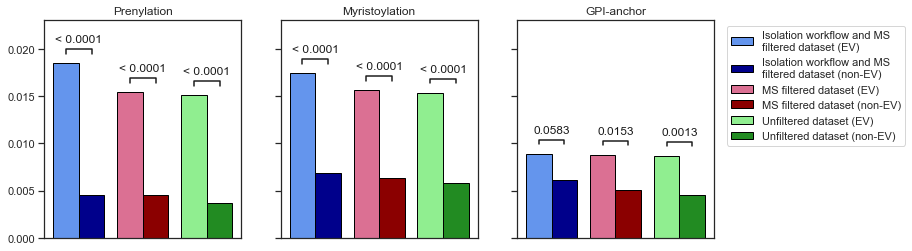

In [19]:
# create subsets of dataframes for PTM types to be plotted
PTMs = ["Prenylation_Uniprot", "Myristoylation_all", "GPI-anchor_Uniprot"]
names_PTMs = ["Prenylation", "Myristoylation", "GPI-anchor"]
subsets = []
for i in PTMs:
    subset = create_subset(i, [df_MS_iso_PTM_melted, df_MS_PTM_melted, df_unfiltered_PTM_melted])
    subsets.append(subset)

# figure settings
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
plt.ylim((0, 0.023))   

x1 = [1, 3, 5]
x2 = [1.8, 3.8, 5.8]

for i, data in enumerate(subsets):
    axs[i].bar([1, 1.8, 3, 3.8, 5, 5.8], data["Fraction"], color=["cornflowerblue", "darkblue", "palevioletred", "darkred", 
        "lightgreen", "forestgreen"], edgecolor="black")
    axs[i].set(xlabel=None, ylabel=None, title=names_PTMs[i], xticks=[])
    y, h = data['Fraction'].iloc[0] + 0.001, 0.0005
    axs[i].plot([1, 1, 1.8, 1.8], [y, y+h, y+h, y], lw=1.5, c='k') 
    axs[i].text((1+1.8)*0.5, y+h*2, print_p_val(EV_MS_iso_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', 
        va='bottom', color='k')
    y, h = data['Fraction'].iloc[2] + 0.001, 0.0005
    axs[i].plot([3, 3, 3.8, 3.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((3+3.8)*.5, y+h*2, print_p_val(EV_MS_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', va='bottom',
        color='k')
    y, h = data['Fraction'].iloc[4] + 0.001, 0.0005
    axs[i].plot([5, 5, 5.8, 5.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((5+5.8)*.5, y+h*2, print_p_val(EV_unfiltered_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', va='bottom',
        color='k')   
    # add legend outside of plots
    if i == 2:
        axs[i].legend(handles=axs[i].patches, labels=labels, bbox_to_anchor=(2, 1))
plt.show()

## Domain barplots

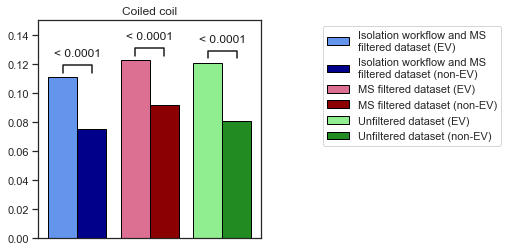

In [20]:
# create subsets of dataframes for PTM types to be plotted
PTMs = ['coiled_coil']       
names_PTMs = ['Coiled coil']
subsets = []
for i in PTMs:
    subset = create_subset(i, [df_MS_iso_PTM_melted, df_MS_PTM_melted, df_unfiltered_PTM_melted])
    subsets.append(subset)

# figure settings
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(4, 4))
plt.ylim((0, 0.15))   

x1 = [1, 3, 5]
x2 = [1.8, 3.8, 5.8]

for i, data in enumerate(subsets):
    axs.bar([1, 1.8, 3, 3.8, 5, 5.8], data["Fraction"], color=["cornflowerblue", "darkblue", "palevioletred", "darkred", 
        "lightgreen", "forestgreen"], edgecolor="black")
    axs.set(xlabel=None, ylabel=None, title=names_PTMs[i], xticks=[])
    y, h = data['Fraction'].iloc[0] + 0.003, 0.005
    axs.plot([1, 1, 1.8, 1.8], [y, y+h, y+h, y], lw=1.5, c='k') 
    axs.text((1+1.8)*0.5, y+h*2, print_p_val(EV_MS_iso_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', 
        va='bottom', color='k')
    y, h = data['Fraction'].iloc[2] + 0.003, 0.005
    axs.plot([3, 3, 3.8, 3.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs.text((3+3.8)*.5, y+h*2, print_p_val(EV_MS_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', va='bottom',
        color='k')
    y, h = data['Fraction'].iloc[4] + 0.003, 0.005
    axs.plot([5, 5, 5.8, 5.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs.text((5+5.8)*.5, y+h*2, print_p_val(EV_unfiltered_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', va='bottom',
        color='k')   
    # add legend outside of plots
    if i == 0:
        axs.legend(handles=axs.patches, labels=labels, bbox_to_anchor=(2.1, 1))

plt.show()

#### Structural features

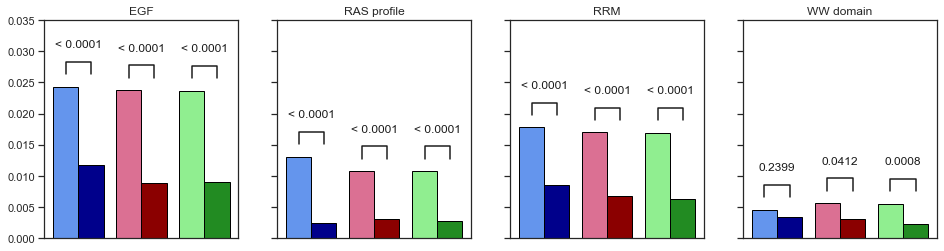

In [21]:
# create subsets of dataframes for PTM types to be plotted
PTMs = ['EGF', 'RAS_profile', 'RRM', 'ww_domain']       
names_PTMs = ['EGF', 'RAS profile', 'RRM', 'WW domain']
subsets = []
for i in PTMs:
    subset = create_subset(i, [df_MS_iso_PTM_melted, df_MS_PTM_melted, df_unfiltered_PTM_melted])
    subsets.append(subset)

# figure settings
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(16, 4))
plt.ylim((0, 0.035))   

x1 = [1, 3, 5]
x2 = [1.8, 3.8, 5.8]

for i, data in enumerate(subsets):
    axs[i].bar([1, 1.8, 3, 3.8, 5, 5.8], data["Fraction"], color=["cornflowerblue", "darkblue", "palevioletred", "darkred", 
        "lightgreen", "forestgreen"], edgecolor="black")
    axs[i].set(xlabel=None, ylabel=None, title=names_PTMs[i], xticks=[])
    y, h = data['Fraction'].iloc[0] + 0.002, 0.002
    axs[i].plot([1, 1, 1.8, 1.8], [y, y+h, y+h, y], lw=1.5, c='k') 
    axs[i].text((1+1.8)*0.5, y+h*2, print_p_val(EV_MS_iso_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', 
        va='bottom', color='k')
    y, h = data['Fraction'].iloc[2] + 0.002, 0.002
    axs[i].plot([3, 3, 3.8, 3.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((3+3.8)*.5, y+h*2, print_p_val(EV_MS_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', va='bottom',
        color='k')
    y, h = data['Fraction'].iloc[4] + 0.002, 0.002
    axs[i].plot([5, 5, 5.8, 5.8], [y, y+h, y+h, y], lw=1.5, c='k')
    axs[i].text((5+5.8)*.5, y+h*2, print_p_val(EV_unfiltered_p_vals.loc[PTMs[i], "P_value_adjusted"]), ha='center', va='bottom',
        color='k')   

plt.show()

## Physicochemical and structural features violinplots

In [22]:
# figure settings
sns.set(style=("ticks"), font_scale=1.2)
x1, x2 = 0, 1 
my_pal = {1: "cornflowerblue", 0: "darkblue"}
dataset = df_MS_iso_filter
P_val_dataset = EV_MS_iso_p_vals
labels = ["EV", "non-EV"]

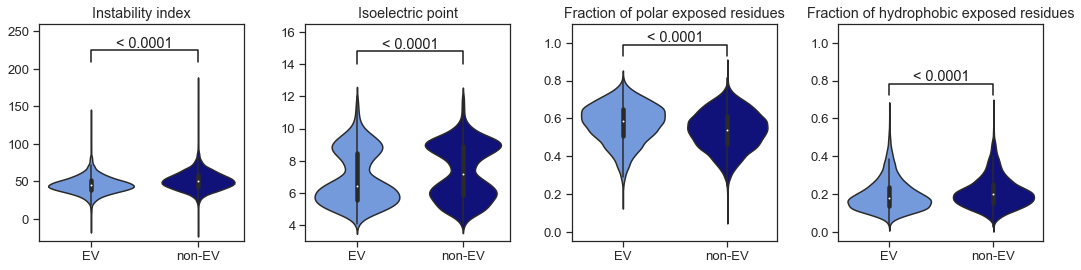

In [23]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False, figsize=(18, 4))

feature='Instability_index'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax1, order=[1, 0], palette=my_pal)
ax1.set(ylabel=None, xlabel=None, title="Instability index", xticklabels=(labels), ylim=(-30, 260))
y, h, col = dataset[feature].max() + 25, 15, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+h, print_p_val(P_val_dataset.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

feature='Isoelectric_point'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax2, order=[1, 0], palette=my_pal)
ax2.set(ylabel=None, xlabel=None, title="Isoelectric point", xticklabels=(labels), ylim=(3, 16.5))
y, h, col = dataset[feature].max() + 2, 0.8, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+h, print_p_val(P_val_dataset.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

feature='Polar_exposed'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax3, order=[1, 0], palette=my_pal)
ax3.set(ylabel=None, xlabel=None, title="Fraction of polar exposed residues", xticklabels=(labels), ylim=(-0.05, 1.1))
y, h, col = dataset[feature].max() + 0.05, 0.06, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+h, print_p_val(P_val_dataset.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

feature='Hydrophobic_exposed'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax4, order=[1, 0], palette=my_pal)
ax4.set(ylabel=None, xlabel=None, title="Fraction of hydrophobic exposed residues", xticklabels=(labels), ylim=(-0.05, 1.1))
y, h, col = dataset[feature].max() + 0.05, 0.06, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+h, print_p_val(P_val_dataset.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)


plt.subplots_adjust(wspace = 0.3)
plt.show()

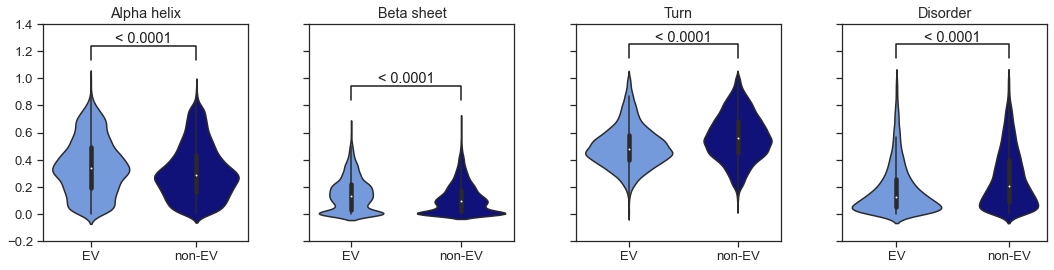

In [24]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(18, 4))
plt.ylim((-0.2, 1.4))

feature='helix'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax1, order=[1, 0], palette=my_pal)
ax1.set(ylabel=None, xlabel=None, title="Alpha helix", xticklabels=(labels))
y, h, col = dataset[feature].max() + 0.15, 0.1, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+h, print_p_val(P_val_dataset.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

feature='sheet'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax2, order=[1, 0], palette=my_pal)
ax2.set(ylabel=None, xlabel=None, title="Beta sheet", xticklabels=(labels))
y, h, col = dataset[feature].max() + 0.15, 0.1, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+h, print_p_val(P_val_dataset.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

feature='turn'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax3, order=[1, 0], palette=my_pal)
ax3.set(ylabel=None, xlabel=None, title="Turn", xticklabels=(labels))
y, h, col = dataset[feature].max() + 0.15, 0.1, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+h, print_p_val(P_val_dataset.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

feature='disorder'
sns.violinplot(x=labels[0], y=feature, data=dataset, ax=ax4, order=[1, 0], palette=my_pal)
ax4.set(ylabel=None, xlabel=None, title="Disorder", xticklabels=(labels))
y, h, col = dataset[feature].max() + 0.15, 0.1, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+h, print_p_val(P_val_dataset.loc[feature, "P_value_adjusted"]), ha='center', va='bottom', color=col)

plt.subplots_adjust(wspace = 0.3)
plt.show()

## Filter effect on molecular weight

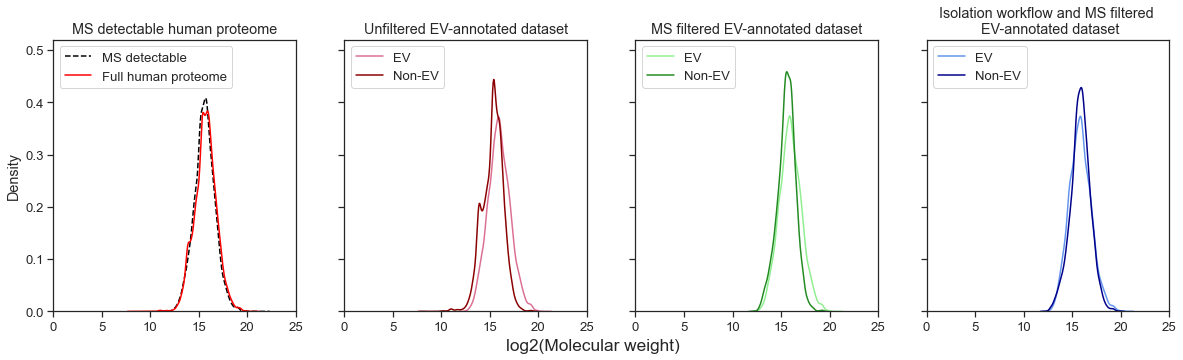

In [25]:
sns.set(style=("ticks"), palette="muted", font_scale=1.2)
fig, axs = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(20, 5))
plt.xlim((0, 25))   
plt.ylim((0, 0.52)) 

sns.kdeplot(x=MS_all['Mass_log'], ax=axs[0], color='black', label='MS detectable', linestyle="--")
sns.kdeplot(x=hp['molecular_weight'], ax=axs[0], color='red', label="Full human proteome")
axs[0].set(xlabel=None, ylabel="Density", title="MS detectable human proteome")
axs[0].legend(handles=axs[0].patches, labels=['MS detectable', 'Full human proteome'], loc="upper left")

sns.kdeplot(x=df_unfiltered[df_unfiltered["EV"] == 1]['molecular_weight'], ax=axs[1], color='palevioletred', 
            label='EV')
sns.kdeplot(x=df_unfiltered[df_unfiltered["EV"] == 0]['molecular_weight'], ax=axs[1], color="darkred", label='Non-EV')
axs[1].set(xlabel=None, ylabel=None, title="Unfiltered EV-annotated dataset")
axs[1].legend(handles=axs[1].patches, labels=['EV', 'Non-EV'], loc="upper left")

# sns.kdeplot(x=MS_all['Mass_log'], ax=axs[1], color='black', label='MS detectable proteins', linestyle="--")
sns.kdeplot(x=df_MS_filter[df_MS_filter["EV"] == 1]['molecular_weight'], ax=axs[2], color='lightgreen', label='EV')
sns.kdeplot(x=df_MS_filter[df_MS_filter["EV"] == 0]['molecular_weight'], ax=axs[2], color="forestgreen", label='Non-EV')
axs[2].set(xlabel=None, ylabel=None, title="MS filtered EV-annotated dataset")
axs[2].legend(handles=axs[2].patches, labels=['EV', 'Non-EV'], loc="upper left")

sns.kdeplot(x=df_MS_iso_filter[df_MS_iso_filter["EV"] == 1]['molecular_weight'], ax=axs[3], color="cornflowerblue", 
            label='EV')
sns.kdeplot(x=df_MS_iso_filter[df_MS_iso_filter["EV"] == 0]['molecular_weight'], ax=axs[3], color="darkblue", 
            label='Non-EV')
axs[3].set(xlabel=None, ylabel=None, title="Isolation workflow and MS filtered \n EV-annotated dataset")
axs[3].legend(handles=axs[3].patches, labels=['EV', 'Non-EV'], loc="upper left")
fig.supxlabel("log2(Molecular weight)")

plt.show()

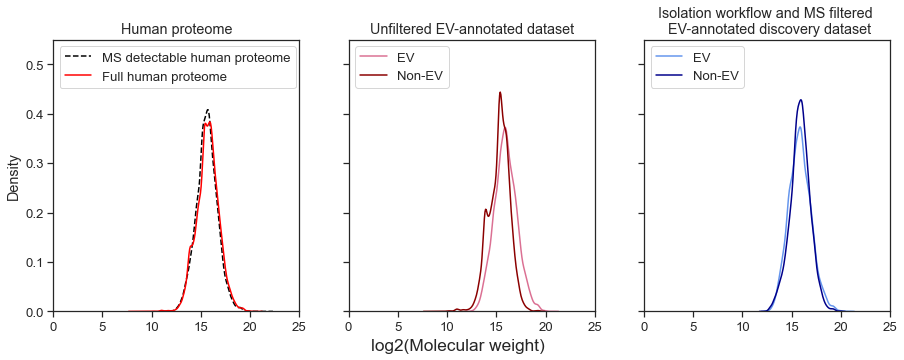

In [26]:
sns.set(style=("ticks"), palette="muted", font_scale=1.2)
fig, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))
plt.xlim((0, 25))   
plt.ylim((0, 0.55)) 

sns.kdeplot(x=MS_all['Mass_log'], ax=axs[0], color='black', label="MS detectable human proteome", linestyle="--")
sns.kdeplot(x=hp['molecular_weight'], ax=axs[0], color='red', label="Full human proteome")
axs[0].set(xlabel=None, ylabel="Density", title="Human proteome")
axs[0].legend(handles=axs[0].patches, labels=["MS detectable human proteome", "Full human proteome"], loc="upper left")

sns.kdeplot(x=df_unfiltered[df_unfiltered["EV"] == 1]['molecular_weight'], ax=axs[1], color='palevioletred', 
            label='EV')
sns.kdeplot(x=df_unfiltered[df_unfiltered["EV"] == 0]['molecular_weight'], ax=axs[1], color="darkred", label='Non-EV')
axs[1].set(xlabel=None, ylabel=None, title="Unfiltered EV-annotated dataset")
axs[1].legend(handles=axs[1].patches, labels=['EV', 'Non-EV'], loc="upper left")

sns.kdeplot(x=df_MS_iso_filter[df_MS_iso_filter["EV"] == 1]['molecular_weight'], ax=axs[2], color="cornflowerblue", 
            label='EV')
sns.kdeplot(x=df_MS_iso_filter[df_MS_iso_filter["EV"] == 0]['molecular_weight'], ax=axs[2], color="darkblue", 
            label='Non-EV')
axs[2].set(xlabel=None, ylabel=None, title="Isolation workflow and MS filtered \n EV-annotated discovery dataset")
axs[2].legend(handles=axs[2].patches, labels=['EV', 'Non-EV'], loc="upper left")
fig.supxlabel("log2(Molecular weight)")

plt.show()

In [27]:
stat, p = mannwhitneyu(EV_MS_iso_1['molecular_weight'], EV_MS_iso_0['molecular_weight']) 
print("P-value MS & isolation method filter:", p)
stat, p = mannwhitneyu(EV_MS_1['molecular_weight'], EV_MS_0['molecular_weight']) 
print("P-value MS filter:", p)
stat, p = mannwhitneyu(EV_unfiltered_1['molecular_weight'], EV_unfiltered_0['molecular_weight']) 
print("P-value no filter:", p)

P-value MS & isolation method filter: 0.0012116109573282088
P-value MS filter: 1.0734940526992309e-85
P-value no filter: 1.1770131331717043e-267
